<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/15_Image_Object_Detection_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv3 Objektum detektálás

Objektum detektálás a **YOLOv3** modell alapján.

Erről a témáról nagyon sokat lehetne írni. Elsősorban arról, hogy működik a Y(ou) O(nly) L(ook) O(nce) algoritmus. Hogy épül fel a mögötte meghúzódó neurális háló. Mi a konvolúció, és így tovább.

Számos keretrendszer van amelyik adaptálta ezt a modelt - TensorFlow, Keras, PyTorch, CNTK, Theano, csak hogy legismertebbeket említsem.

De ebben a példában csak említést teszek róla, mivel nem tartozik szorosan a tárgyhoz és a téma egyébként is nagyobb és szerteágazóbb annál mintsem, hogy egy Jupyter Notebookban be tudjam muatni.

### Röviden

Egy olyan **felügyelt gépi tanulásról** van szó, amely képek alapján képes bizonyos tárgyakat felismerni és lokalizálni egy képen.

Ha lesz még időm, akkor viszont bővíteni fogom ezt a jegyzetet, amely jó kiindulási alap lehet a 'Bevezetés a mély neurális hálókba és a gépi tanulásba'

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import cv2

import skimage
import skimage.io

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## A CoCo (Common Object in Context)
---
Aki erről szeretne többet megtudni az látogasson el az alábbi címre https://cocodataset.org/#home


In [3]:
# Cimke nevek
!curl --progress-bar -O https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

######################################################################## 100.0%


In [4]:
# Konfiguráció
!curl --progress-bar -O https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

######################################################################## 100.0%


In [5]:
# Súlyok
!curl --progress-bar -O https://pjreddie.com/media/files/yolov3.weights

######################################################################## 100.0%


## Az adatok beolvasása és előkészítése
---

In [6]:
# Read classes
CLASSES = []
with open("coco.names", "r") as f:
    CLASSES = [line.strip() for line in f.readlines()]

# Színkodólás
np.random.seed(1)
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))
COLORS /= (np.sum(COLORS**2, axis=1)**0.5/255)[np.newaxis].T

# model beolvasása
MODEL = cv2.dnn.readNet(
    'yolov3.weights',
    'yolov3.cfg'
)

# Kimeneti réteg
OUTPUT_LAYERS = [MODEL.getLayerNames()[i[0] - 1] for i in MODEL.getUnconnectedOutLayers()]

In [24]:

image = skimage.io.imread('https://github.com/JoDeMiro/ImageProcessing/blob/main/images/people1.jpg?raw=true')

b, g, r = cv2.split(image)

IMG_IN = cv2.merge((r, g, b))

## Objektum detektálás
---

In [25]:
def objectDetection(IMG_IN):
    height, width, channels = IMG_IN.shape
    blob = cv2.dnn.blobFromImage(IMG_IN, 1/255, (416, 416), swapRB=True, crop=False)

    MODEL.setInput(blob)
    outs = MODEL.forward(OUTPUT_LAYERS)

    # Show infos
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                # Rectangle coordinates
                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Körberajzoljuk a megtalált objektumot
    IMG_OUT = IMG_IN.copy()
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(CLASSES[class_ids[i]])
            color = COLORS[class_ids[i]]
            cv2.rectangle(IMG_OUT, (x, y), (x + w, y + h), color, 2)
            cv2.putText(IMG_OUT, label, (x, y - 5), font, 2, color, 2)
    
    return IMG_OUT, label

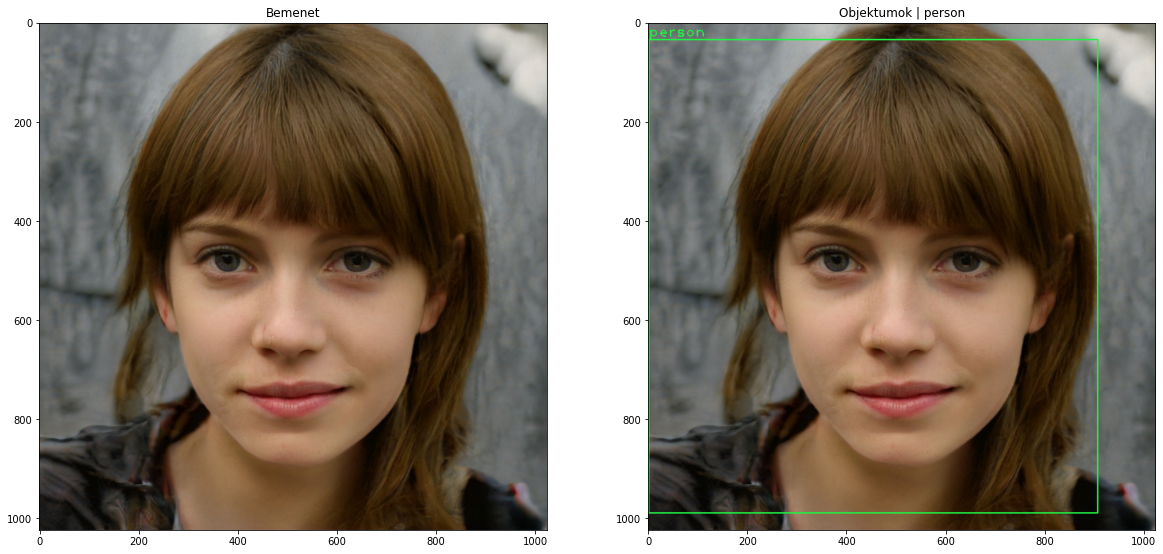

In [29]:
fig, (axA, axB) = plt.subplots(1, 2)

axA.imshow(IMG_IN)
axA.set_title("Bemenet")

IMG_OUT, label = objectDetection(IMG_IN)
axB.imshow(IMG_OUT)
axB.set_title(f'Objektumok | {label}')

plt.show()

## További példák
---

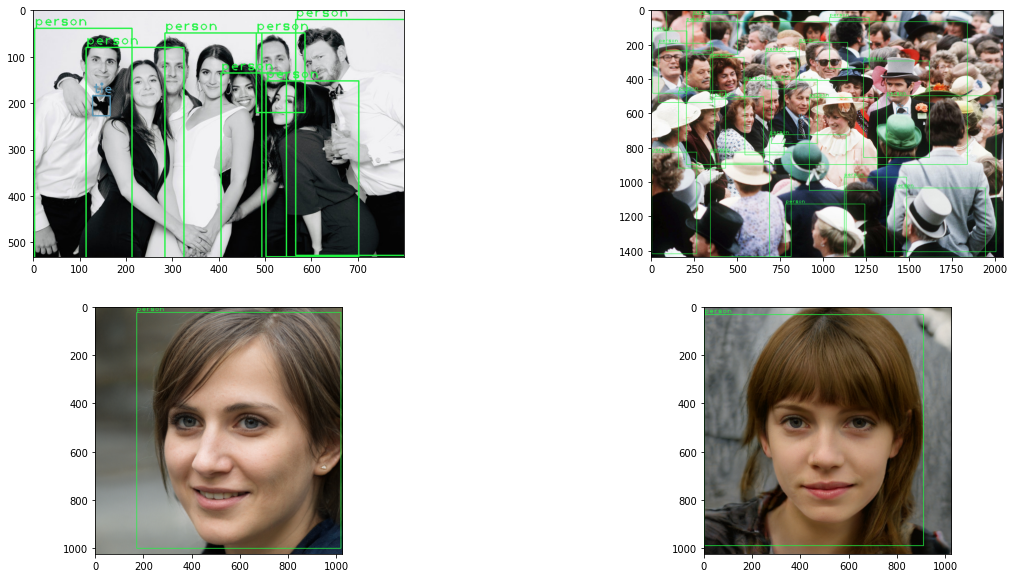

In [28]:
IMGS = ['people1', 'people2', 'woman1', 'woman2']

fig, axs = plt.subplots(2, 2)
axs = [b for a in axs for b in a]

for i, ax in enumerate(axs):

    image = skimage.io.imread(f'https://github.com/JoDeMiro/ImageProcessing/blob/main/images/{IMGS[i]}.jpg?raw=true')

    b, g, r = cv2.split(image)
    r, g, b = cv2.split(image)
    IMG_IN = cv2.merge((r, g, b))

    IMG_OUT, label = objectDetection(IMG_IN)
    ax.imshow(IMG_OUT)